# Analysing Performance of Stocks using Causal Discovery

## Setup

Import the datasets:

In [1]:
linux = True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if linux:
    if module_path not in sys.path:
        sys.path.append(module_path+"/DataPreprocessing")
else:
    if module_path not in sys.path:
        sys.path.append(module_path+"\\DataPreprocessing")

## Data Preprocessing

In [3]:
if linux:
    # lab computers
    data_dir = "/home/diego.sanez/Documents/ML703_Project/Datasets/"
else:
    data_dir = "C:/Users/diego/iCloudDrive/Documents/MBZUAI Sem/Semester 2/ML703 Probabilistic and Statistical Inference/Project/JN/Datasets/"

company = pd.read_csv(data_dir + "Company.csv")
companyValues = pd.read_csv(data_dir + "CompanyValues.csv")
companyTweet = pd.read_csv(data_dir + "Company_Tweet.csv")
tweet = pd.read_csv(data_dir + "Tweet.csv")
tweet = tweet.merge(companyTweet, on="tweet_id", how='inner')

In [4]:
print(f"Stocks from {company.ticker_symbol.unique()}")

selected_stock = 'TSLA'
print(f"Stock selected: {selected_stock}")
companyValuesSub = companyValues[companyValues.ticker_symbol == selected_stock]
tweetSub = tweet[tweet.ticker_symbol == selected_stock]

Stocks from ['AAPL' 'GOOG' 'GOOGL' 'AMZN' 'TSLA' 'MSFT']
Stock selected: TSLA


In [5]:
print(f"Company values: \n{companyValuesSub.head(3)}")
print(f"Company tweets: \n{tweetSub.head(3)}")

Company values: 
      ticker_symbol    day_date  close_value    volume  open_value  \
14463          TSLA  2020-05-29       835.00  11812490      808.75   
14464          TSLA  2020-05-28       805.81   7275774      813.51   
14465          TSLA  2020-05-27       820.23  11549530      820.86   

       high_value  low_value  
14463      835.00     804.21  
14464      824.75     801.69  
14465      827.71     785.00  
Company tweets: 
             tweet_id         writer   post_date  \
3  550442977802207232   ShowDreamCar  1420070807   
5  550443807834402816   i_Know_First  1420071005   
7  550443808606126081  aaplstocknews  1420071005   

                                                body  comment_num  \
3  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...            0   
5  Swing Trading: Up To 8.91% Return In 14 Days h...            0   
7  Swing Trading: Up To 8.91% Return In 14 Days h...            0   

   retweet_num  like_num ticker_symbol  
3            0         1          

## One Company Analysis

### Tweet data preprocessing

In [6]:
from data import set_datetime, detrend_ts

tweetSub['date'] = set_datetime(tweetSub.post_date)

tweetSubMetrics = tweetSub[['date', 'comment_num', 'retweet_num', 'like_num']]
tweetSubMetrics = tweetSubMetrics.groupby(["date"]).sum()
tweetSubMetrics2019 = tweetSubMetrics[(tweetSubMetrics.index >= pd.to_datetime("2018/12/25")) \
    & (tweetSubMetrics.index <= pd.to_datetime("2019/12/31"))]

tweetSubMetrics2019.head(3)

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,comment_num,retweet_num,like_num
date,,,
2018-12-25,432,354,3395
2018-12-26,602,815,5048
2018-12-27,778,709,5513


In [7]:
tweetSubMetrics2019['log_retweet_num'] = np.log(tweetSubMetrics2019['retweet_num'])
tweetSubMetrics2019['log_comment_num'] = np.log(tweetSubMetrics2019['comment_num'])

tweetSubMetrics2019['detrended_log_comment_num'] = detrend_ts(tweetSubMetrics2019.log_comment_num)

tweetSubMetrics2019 = tweetSubMetrics2019[-365:]

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


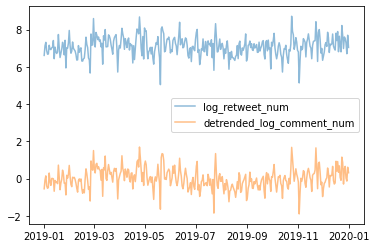

In [8]:
plt.plot(tweetSubMetrics2019.log_retweet_num, alpha=0.5, label="log_retweet_num")
plt.plot(tweetSubMetrics2019.detrended_log_comment_num, alpha=0.5, label="detrended_log_comment_num")
plt.legend()

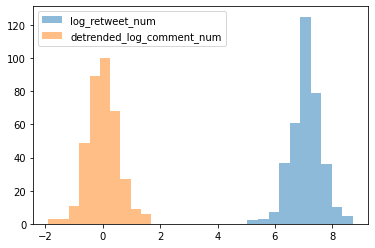

In [9]:
plt.hist(tweetSubMetrics2019.log_retweet_num, alpha=0.5, label="log_retweet_num")
plt.hist(tweetSubMetrics2019.detrended_log_comment_num, alpha=0.5, label="detrended_log_comment_num")
plt.legend()

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(tweetSubMetrics2019.log_retweet_num)
print('Log Retweet Number test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

result = adfuller(tweetSubMetrics2019.detrended_log_comment_num)
print('Detrended Log Tweet Comment Number test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Log Retweet Number test:
ADF Statistic: -3.677427
p-value: 0.004442
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Detrended Log Tweet Comment Number test:
ADF Statistic: -2.804106
p-value: 0.057690
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


### Value data preprocessing

In [11]:
companyValuesSub['date'] = pd.to_datetime(companyValuesSub['day_date']).dt.date
companyValuesSubMetrics = companyValuesSub[['date', 'close_value', 'volume', 'open_value', 'high_value', 'low_value']]
companyValuesSubMetrics = companyValuesSubMetrics.groupby(['date']).sum()
companyValuesSubMetrics2019 = companyValuesSubMetrics[(companyValuesSubMetrics.index >= pd.to_datetime("2018/12/25")) \
    & (companyValuesSubMetrics.index <= pd.to_datetime("2019/12/31"))]

companyValuesSubMetrics2019.head(3)

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,close_value,volume,open_value,high_value,low_value
date,,,,,
2018-12-25,295.39,5559913,313.50,314.5000,295.195
2018-12-26,326.09,8143102,300.00,326.9700,294.090
2018-12-27,316.13,8567385,319.84,322.1717,301.500


/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/diego.sanez/Documents/ML703_Project/ml703_timeSeriesCausalDiscovery/DataPreprocessing/data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[lag_column] = temp[-final_ts_len:]


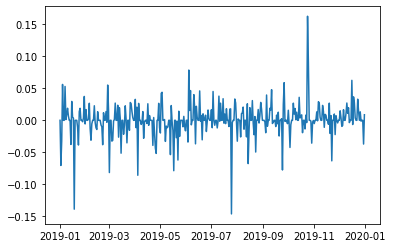

In [12]:
from data import set_datetime, detrend_ts, take_diff_ts

companyValuesSubMetrics2019['log_close_value'] = np.log(companyValuesSubMetrics2019['close_value'])

companyValuesSubMetrics2019 = take_diff_ts(data=companyValuesSubMetrics2019, \
    ts_column='log_close_value', lag_column='lag_log_close_value', lag=1, final_ts_len=365)

plt.plot(companyValuesSubMetrics2019.lag_log_close_value)

(array([  2.,   1.,   8.,  28., 227.,  83.,  13.,   2.,   0.,   1.]),
 array([-0.14634122, -0.11543636, -0.0845315 , -0.05362664, -0.02272178,
         0.00818308,  0.03908794,  0.0699928 ,  0.10089766,  0.13180252,
         0.16270738]),
 <BarContainer object of 10 artists>)

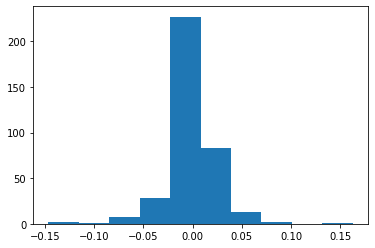

In [13]:
plt.hist(companyValuesSubMetrics2019.lag_log_close_value)

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(companyValuesSubMetrics2019.lag_log_close_value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.635766
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [15]:
dataFrame = np.column_stack((companyValuesSubMetrics2019.lag_log_close_value,
                    tweetSubMetrics2019.log_retweet_num,
                    tweetSubMetrics2019.detrended_log_comment_num))
dataFrame[:5]

array([[ 0.        ,  6.61204103, -0.54695628],
       [-0.07058239,  7.12849595, -0.07861812],
       [-0.03197756,  7.31388683,  0.14831061],
       [ 0.05609431,  6.87005341, -0.38452907],
       [ 0.        ,  6.67708346, -0.51965665]])

Text(0, 0.5, 'log_retweet_num')

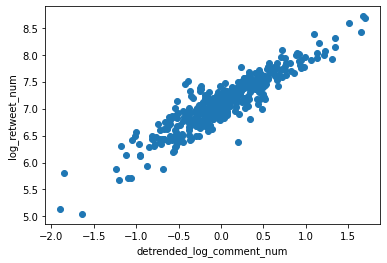

In [16]:
plt.scatter(dataFrame[:, 2], dataFrame[:, 1])
plt.xlabel("detrended_log_comment_num")
plt.ylabel("log_retweet_num")

### Causal Discovery

In [17]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
plt.style.use('ggplot')

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/tigramite-4.2.2.1-py3.7-linux-x86_64.egg/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'torch'
  warnings.warn(str(e))


In [18]:
# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$Y^0$', r'$Y^1$']
dataframe = pp.DataFrame(dataFrame, 
                         datatime = np.arange(len(dataFrame)), 
                         var_names=var_names)

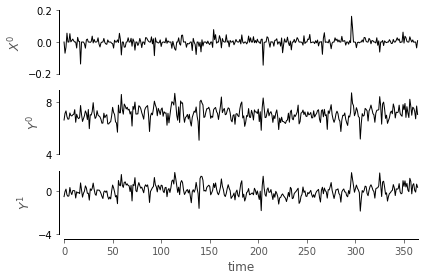

In [19]:
tp.plot_timeseries(dataframe); plt.show()

#### Partial Correlation

In [20]:
parcorr = ParCorr(significance='analytic')

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 28


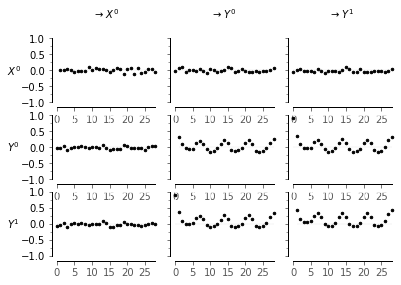

In [21]:
correlations = pcmci.get_lagged_dependencies(tau_max=28, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [22]:
results = pcmci.run_pcmci(tau_max=8, pc_alpha=0.5)
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 5 link(s):
        ($Y^1$ -5): max_pval = 0.30359, min_val =  0.056
        ($Y^0$ -2): max_pval = 0.41466, min_val =  0.044
        ($X^0$ -8): max_pval = 0.43587, min_val = -0.042
        ($X^0$ -4): max_pval = 0.43893, min_val =  0.042
        ($Y^0$ -7): max_pval = 0.47537, min_val =  0.038

    Variable $Y^0$ has 9 link(s):
        ($Y^1$ -1): max_pval = 0.00608, min_val =  0.147
        ($Y^1$ -7): max_pval = 0.03173, min_val =  0.116
        ($X^0$ -2): max_pval = 0.05275, min_val =  0.105
        ($Y^1$ -6): max_pval = 0.09310, min_val =  0.090
        ($Y^1$ -2): max_pval = 0.27132, min_val = -0.060
        ($X^0$ -1): max_pval = 0.31320, min_val =  0.054
        ($X^0$ -7): max_pval = 0.33467, min_val =  0.052
        ($Y^0$ -4): max

In [23]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $Y^0$ has 2 link(s):
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.909
        ($Y^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.330

    Variable $Y^1$ has 2 link(s):
        ($Y^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.909
        ($Y^1$ -1): pval = 0.00001 | qval = 0.00023 | val =  0.244


In [24]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

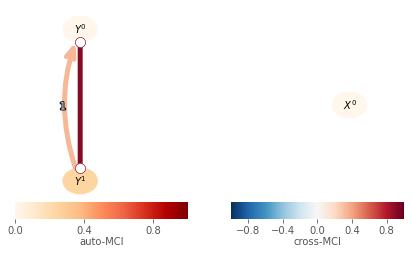

In [25]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

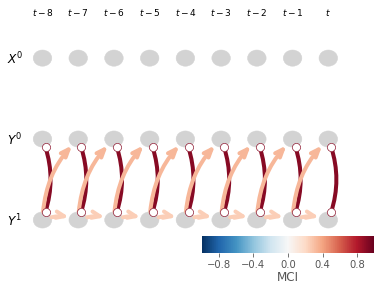

In [26]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

#### Gaussian Processes

In [27]:
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    verbosity=0)

In [28]:
results = pcmci_gpdc.run_pcmci(tau_max=8, pc_alpha=0.5)
pcmci_gpdc.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


## Significant links at alpha = 0.01:

    Variable $X^0$ has 4 link(s):
        ($Y^1$  0): pval = 0.00000 | val =  0.216
        ($Y^0$  0): pval = 0.00100 | val =  0.172
        ($X^0$ -7): pval = 0.00300 | val =  0.162
        ($Y^1$ -7): pval = 0.00900 | val =  0.151

    Variable $Y^0$ has 3 link(s):
        ($Y^1$  0): pval = 0.00000 | val =  0.811
        ($X^0$  0): pval = 0.00100 | val =  0.172
        ($X^0$ -1): pval = 0.00300 | val =  0.164

    Variable $Y^1$ has 4 link(s):
        ($Y^0$  0): pval = 0.00000 | val =  0.811
        ($Y^1$ -1): pval = 0.00000 | val =  0.372
        ($X^0$  0): pval = 0.00000 | val =  0.216
        ($Y^1$ -7): pval = 0.00000 | val =  0.178


In [29]:
q_matrix = pcmci_gpdc.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci_gpdc.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.216
        ($Y^0$  0): pval = 0.00100 | qval = 0.00100 | val =  0.172

    Variable $Y^0$ has 2 link(s):
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.811
        ($X^0$  0): pval = 0.00100 | qval = 0.00100 | val =  0.172

    Variable $Y^1$ has 4 link(s):
        ($Y^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.811
        ($Y^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.372
        ($X^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.216
        ($Y^1$ -7): pval = 0.00000 | qval = 0.00000 | val =  0.178


In [30]:
link_matrix = pcmci_gpdc.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

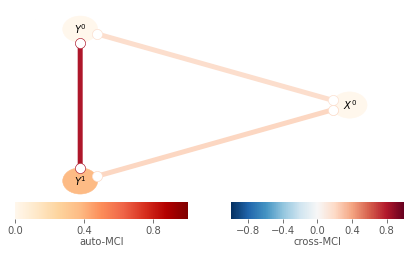

In [31]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

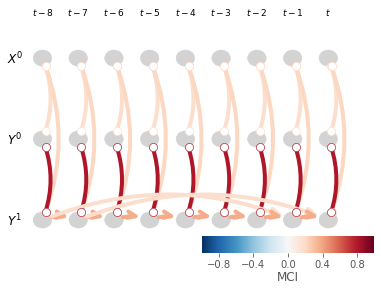

In [32]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

## All Companies Analysis

### Tweet data preprocessing

In [33]:
from data import set_datetime, detrend_ts
from pandas.tseries.offsets import BDay

## Remove weekend values since the stock price is not given for these days
tweet['date'] = set_datetime(tweet.post_date)
isBusinessDay = BDay().onOffset

isBusinessDay
match_series = pd.to_datetime(tweet['date']).map(isBusinessDay)
tweetWD = tweet[match_series]

tweetMetrics = tweetWD[['ticker_symbol', 'date', 'comment_num', 'retweet_num', 'like_num']]
tweetMetrics = tweetMetrics.groupby(["ticker_symbol", "date"]).sum().reset_index()
tweetMetrics = tweetMetrics.pivot(index='date', columns=['ticker_symbol'])
tweetMetrics.columns = ["_".join(col) for col in tweetMetrics.columns]


# 2019 year period
tweetMetrics2019 = tweetMetrics[(tweetMetrics.index >= pd.to_datetime("2018/12/25")) \
    & (tweetMetrics.index <= pd.to_datetime("2019/12/31"))]

# 2015 - 2019 year period
tweetMetrics1519 = tweetMetrics[(tweetMetrics.index >= pd.to_datetime("2014/12/31")) \
    & (tweetMetrics.index <= pd.to_datetime("2019/12/31"))]

print(tweetMetrics1519.shape)
tweetMetrics1519.head(3)

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/pandas/core/base.py:870: FutureWarning: onOffset is a deprecated, use is_on_offset instead
  new_values = map_f(values, mapper)


(1304, 18)


/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,comment_num_AAPL,comment_num_AMZN,comment_num_GOOG,comment_num_GOOGL,comment_num_MSFT,comment_num_TSLA,retweet_num_AAPL,retweet_num_AMZN,retweet_num_GOOG,retweet_num_GOOGL,retweet_num_MSFT,retweet_num_TSLA,like_num_AAPL,like_num_AMZN,like_num_GOOG,like_num_GOOGL,like_num_MSFT,like_num_TSLA
date,,,,,,,,,,,,,,,,,,
2015-01-01,17,44,0,0,1,19,968,699,11,3,19,40,227,188,21,27,49,81
2015-01-02,128,11,9,5,6,47,2102,370,24,10,2,53,562,89,50,29,27,142
2015-01-05,139,15,18,9,15,21,392,52,62,41,69,75,554,123,143,96,93,191


In [34]:
for col in tweetMetrics1519.columns:
    print(f"Processing {col}")
    if sum(tweetMetrics1519[col] == 0) > 0:
        tweetMetrics1519[f'sqrt_{col}'] = np.sqrt(tweetMetrics1519[col])
        tweetMetrics1519[f'detrended_sqrt_{col}'] = detrend_ts(tweetMetrics1519[f'sqrt_{col}'])
    else:
        tweetMetrics1519[f'log_{col}'] = np.log(tweetMetrics1519[col])
        tweetMetrics1519[f'detrended_log_{col}'] = detrend_ts(tweetMetrics1519[f'log_{col}'])

tweetMetrics1519 = tweetMetrics1519[-1304:]

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Processing comment_num_AAPL
Processing comment_num_AMZN
Processing comment_num_GOOG
Processing comment_num_GOOGL
Processing comment_num_MSFT
Processing comment_num_TSLA
Processing retweet_num_AAPL
Processing retweet_num_AMZN
Processing retweet_num_GOOG
Processing retweet_num_GOOGL
Processing retweet_num_MSFT
Processing retweet_num_TSLA
Processing like_num_AAPL
Processing like_num_AMZN
Processing like_num_GOOG
Processing like_num_GOOGL
Processing like_num_MSFT
Processing like_num_TSLA


/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [35]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import zivot_andrews

stationary_cols = []

for col in tweetMetrics1519.columns:
    adf_result = adfuller(tweetMetrics1519[col])
    print(f'{col.upper()} test:')
    print(f'ADF Statistic: {adf_result[0]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('p-value: %f' % adf_result[1])
    print("Non-Stationary") if adf_result[1] > 0.05 else print("Stationary")
    
    # t_stat, p_value, critical_values, _, _ = zivot_andrews(stationary_with_break[0].values)
    za_result = zivot_andrews(tweetMetrics1519[col])
    print(f'Zivot-Andrews Statistic: {za_result[0]:.2f}')
    for key, value in za_result[2].items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')
    print(f'\np-value: {za_result[1]:.2f}')
    print("Non-Stationary") if za_result[1] > 0.05 else print("Stationary")

    if (adf_result[1] < 0.05) & (za_result[1] < 0.05):
        stationary_cols.append(col)

len(stationary_cols)

COMMENT_NUM_AAPL test:
ADF Statistic: -5.655036807902873
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value: 0.000001
Stationary
Zivot-Andrews Statistic: -7.28
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
COMMENT_NUM_AMZN test:
ADF Statistic: -3.308320956067472
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value: 0.014511
Stationary
Zivot-Andrews Statistic: -7.44
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
COMMENT_NUM_GOOG test:
ADF Statistic: -15.769026136090748
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value: 0.000000
Stationary
Zivot-Andrews Statistic: -16.51
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
COMMENT_NUM_GOOGL test:
ADF Statistic: -8.019091001078179
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value: 0.000000
Stationary
Zi

45

In [36]:
stationary_cols[-25:]

['detrended_sqrt_comment_num_GOOG',
 'sqrt_comment_num_GOOGL',
 'detrended_sqrt_comment_num_GOOGL',
 'sqrt_comment_num_MSFT',
 'detrended_sqrt_comment_num_MSFT',
 'detrended_log_comment_num_TSLA',
 'log_retweet_num_AAPL',
 'detrended_log_retweet_num_AAPL',
 'log_retweet_num_AMZN',
 'detrended_log_retweet_num_AMZN',
 'sqrt_retweet_num_GOOG',
 'detrended_sqrt_retweet_num_GOOG',
 'log_retweet_num_GOOGL',
 'detrended_log_retweet_num_GOOGL',
 'log_retweet_num_MSFT',
 'detrended_log_retweet_num_MSFT',
 'detrended_log_retweet_num_TSLA',
 'log_like_num_AAPL',
 'detrended_log_like_num_AAPL',
 'detrended_log_like_num_AMZN',
 'log_like_num_GOOG',
 'detrended_log_like_num_GOOG',
 'log_like_num_GOOGL',
 'detrended_log_like_num_GOOGL',
 'detrended_log_like_num_MSFT']

In [37]:
selected_stationary_cols = []
selected_stationary_cols.append('log_retweet_num_AAPL')
selected_stationary_cols.append('log_retweet_num_AMZN')
selected_stationary_cols.append('sqrt_retweet_num_GOOG')
selected_stationary_cols.append('log_retweet_num_GOOGL')
selected_stationary_cols.append('log_retweet_num_MSFT')
selected_stationary_cols.append('detrended_log_retweet_num_TSLA')
selected_stationary_cols

['log_retweet_num_AAPL',
 'log_retweet_num_AMZN',
 'sqrt_retweet_num_GOOG',
 'log_retweet_num_GOOGL',
 'log_retweet_num_MSFT',
 'detrended_log_retweet_num_TSLA']

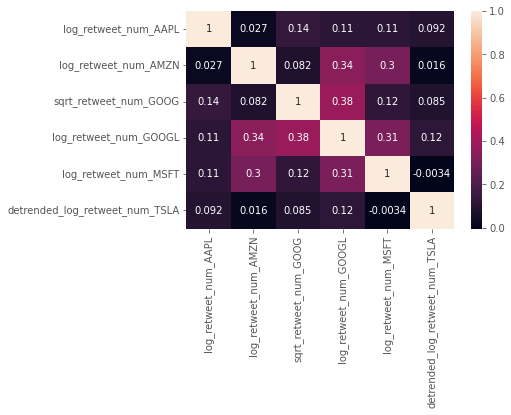

In [39]:
import seaborn as sns

# Correlation between Stationary variables
corrMatrix = tweetMetrics1519[selected_stationary_cols].corr(method="pearson")
sns.heatmap(corrMatrix, annot=True)
plt.savefig("./Correlation Plots/all_companies_tweets_corr.png", dpi=300, bbox_inches = 'tight')

In [40]:
abs(corrMatrix[:]) > 0.75

,log_retweet_num_AAPL,log_retweet_num_AMZN,sqrt_retweet_num_GOOG,log_retweet_num_GOOGL,log_retweet_num_MSFT,detrended_log_retweet_num_TSLA
log_retweet_num_AAPL,True,False,False,False,False,False
log_retweet_num_AMZN,False,True,False,False,False,False
sqrt_retweet_num_GOOG,False,False,True,False,False,False
log_retweet_num_GOOGL,False,False,False,True,False,False
log_retweet_num_MSFT,False,False,False,False,True,False
detrended_log_retweet_num_TSLA,False,False,False,False,False,True


In [41]:
tweetMetricsFinal = tweetMetrics1519[selected_stationary_cols]

tweetMetricsFinal.head(3)

,log_retweet_num_AAPL,log_retweet_num_AMZN,sqrt_retweet_num_GOOG,log_retweet_num_GOOGL,log_retweet_num_MSFT,detrended_log_retweet_num_TSLA
date,,,,,,
2015-01-01,0.032249,0.034142,0.009426,0.006678,0.018232,-0.019055
2015-01-02,0.035886,0.030826,0.013922,0.013997,0.004292,-0.009115
2015-01-05,0.028009,0.020597,0.022377,0.022574,0.026218,0.003169


### Value data preprocessing

In [42]:
from pandas.tseries.offsets import BDay

## Remove weekend values since the stock price is not given for these days
companyValues['date'] = pd.to_datetime(companyValues['day_date']).dt.date
isBusinessDay = BDay().onOffset

isBusinessDay
match_series = pd.to_datetime(companyValues['date']).map(isBusinessDay)
companyValuesWD = companyValues[match_series]

companyValuesMetrics = companyValuesWD[['ticker_symbol', 'date', 'close_value', 'volume', 'open_value', 'high_value', 'low_value']]
companyValuesMetrics = companyValuesMetrics.groupby(["ticker_symbol", 'date']).sum().reset_index()
companyValuesMetrics = companyValuesMetrics.pivot(index='date', columns=['ticker_symbol'])
companyValuesMetrics.columns = ["_".join(col) for col in companyValuesMetrics.columns]

# 2019 year period
companyValuesMetrics2019 = companyValuesMetrics[(companyValuesMetrics.index >= pd.to_datetime("2018/12/25")) \
    & (companyValuesMetrics.index <= pd.to_datetime("2019/12/31"))]

# 2015 - 2019 year period
companyValuesMetrics1519 = companyValuesMetrics[(companyValuesMetrics.index >= pd.to_datetime("2014/12/31")) \
    & (companyValuesMetrics.index <= pd.to_datetime("2019/12/31"))]

print(companyValuesMetrics1519.shape)
companyValuesMetrics1519.head(3)

(1305, 30)


/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/pandas/core/base.py:870: FutureWarning: onOffset is a deprecated, use is_on_offset instead
  new_values = map_f(values, mapper)
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,close_value_AAPL,close_value_AMZN,close_value_GOOG,close_value_GOOGL,close_value_MSFT,close_value_TSLA,volume_AAPL,volume_AMZN,volume_GOOG,volume_GOOGL,...,high_value_GOOG,high_value_GOOGL,high_value_MSFT,high_value_TSLA,low_value_AAPL,low_value_AMZN,low_value_GOOG,low_value_GOOGL,low_value_MSFT,low_value_TSLA
date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,110.38,310.35,526.40,530.66,46.45,222.41,41304780.0,2048676.0,1367110.0,1235889.0,...,532.60,538.4,47.44,225.68,110.21,310.0100,525.8,530.20,46.45,222.25
2015-01-01,110.38,310.35,526.40,530.66,46.45,222.41,41304780.0,2048676.0,1367110.0,1235889.0,...,532.60,538.4,47.44,225.68,110.21,310.0100,525.8,530.20,46.45,222.25
2015-01-02,109.33,308.52,524.81,529.55,46.76,219.31,53143770.0,2785167.0,1444809.0,1325271.0,...,531.27,535.8,47.42,223.25,107.35,306.9601,524.1,527.88,46.54,213.26


In [43]:
companyValuesMetrics1519.columns[:6]
# companyValuesMetrics1519[-1304:].shape

Index(['close_value_AAPL', 'close_value_AMZN', 'close_value_GOOG',
       'close_value_GOOGL', 'close_value_MSFT', 'close_value_TSLA'],
      dtype='object')

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

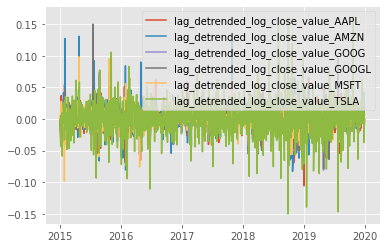

In [44]:
from data import set_datetime, detrend_ts, take_diff_ts

companyCloseValuesMetrics1519 = companyValuesMetrics1519[companyValuesMetrics1519.columns[:6]]

for col in companyCloseValuesMetrics1519.columns:
    companyCloseValuesMetrics1519[f'log_{col}'] = np.log(companyCloseValuesMetrics1519[col])
for col in companyCloseValuesMetrics1519.columns:
    companyCloseValuesMetrics1519[f'detrended_{col}'] = detrend_ts(companyCloseValuesMetrics1519[f'{col}'])

# Take differencing
lag = 1
final_ts_len = 1304
temp_lag = {}
for col in companyCloseValuesMetrics1519.columns:
    temp = np.diff(companyCloseValuesMetrics1519[col], n=lag)
    temp_lag[f"lag_{col}"] = temp
companyCloseValuesMetrics1519 = companyCloseValuesMetrics1519[-final_ts_len:]
for col in companyCloseValuesMetrics1519.columns:
    companyCloseValuesMetrics1519[f"lag_{col}"] = temp_lag[f"lag_{col}"][-final_ts_len:]

for col in companyCloseValuesMetrics1519.columns[-6:]:
    plt.plot(companyCloseValuesMetrics1519[f'{col}'], label=f'{col}')
plt.legend()

In [45]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import zivot_andrews

stationary_cols = []

for col in companyCloseValuesMetrics1519.columns:
    adf_result = adfuller(companyCloseValuesMetrics1519[col])
    print(f'{col.upper()} test:')
    print(f'ADF Statistic: {adf_result[0]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('p-value: %f' % adf_result[1])
    print("Non-Stationary") if adf_result[1] > 0.05 else print("Stationary")
    
    # t_stat, p_value, critical_values, _, _ = zivot_andrews(stationary_with_break[0].values)
    za_result = zivot_andrews(companyCloseValuesMetrics1519[col])
    print(f'Zivot-Andrews Statistic: {za_result[0]:.2f}')
    for key, value in za_result[2].items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')
    print(f'\np-value: {za_result[1]:.2f}')
    print("Non-Stationary") if za_result[1] > 0.05 else print("Stationary")

    if (adf_result[1] < 0.05) & (za_result[1] < 0.05):
        stationary_cols.append(col)

len(stationary_cols)

CLOSE_VALUE_AAPL test:
ADF Statistic: 1.055651664948278
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value: 0.994820
Non-Stationary
Zivot-Andrews Statistic: -1.81
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 1.00
Non-Stationary
CLOSE_VALUE_AMZN test:
ADF Statistic: -0.8407237639557726
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value: 0.806866
Non-Stationary
Zivot-Andrews Statistic: -4.41
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.15
Non-Stationary
CLOSE_VALUE_GOOG test:
ADF Statistic: -0.8273347937513253
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value: 0.810961
Non-Stationary
Zivot-Andrews Statistic: -4.78
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.06
Non-Stationary
CLOSE_VALUE_GOOGL test:
ADF Statistic: -0.9501535503930998
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value

28

In [46]:
stationary_cols[4:10]

['lag_close_value_AAPL',
 'lag_close_value_AMZN',
 'lag_close_value_GOOG',
 'lag_close_value_GOOGL',
 'lag_close_value_MSFT',
 'lag_close_value_TSLA']

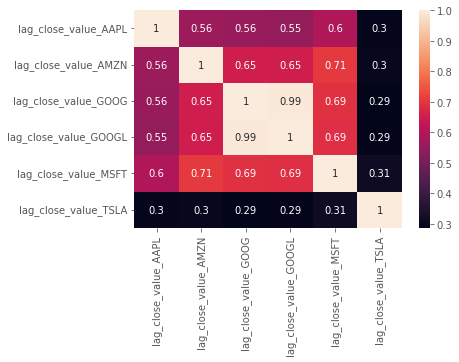

In [47]:
import seaborn as sns

# Correlation between Stationary variables
corrMatrix = companyCloseValuesMetrics1519[stationary_cols[4:10]].corr(method="pearson")
sns.heatmap(corrMatrix, annot=True)
plt.savefig("./Correlation Plots/all_companies_returns_corr.png", dpi=300, bbox_inches = 'tight')

In [48]:
companyCloseValuesMetricsFinal = companyCloseValuesMetrics1519[stationary_cols[4:10]]

companyCloseValuesMetricsFinal.head(3)

,lag_close_value_AAPL,lag_close_value_AMZN,lag_close_value_GOOG,lag_close_value_GOOGL,lag_close_value_MSFT,lag_close_value_TSLA
date,,,,,,
2015-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-02,-0.011900,-0.002362,-0.003206,-0.002229,0.007172,-0.011175
2015-01-05,-0.034906,-0.008170,-0.022058,-0.020259,-0.010063,-0.033236


### Causal Discovery

In [49]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
plt.style.use('ggplot')

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC

In [50]:
dataFrameCompanies = np.column_stack((
    companyCloseValuesMetricsFinal,
    tweetMetricsFinal))
dataFrameCompanies[:5].shape

(5, 12)

In [81]:
# Initialize dataframe object, specify time axis and variable names
var_names_companies = [r'$X^1$', r'$X^2$', r'$X^3$', r'$X^4$', r'$X^5$', r'$X^6$', 
r'$X^7$', r'$X^8$', r'$X^9$', r'$X^{10}$', r'$X^{11}$', r'$X^{12}$',]
dataframe_companies = pp.DataFrame(dataFrameCompanies, 
                         datatime = np.arange(len(dataFrameCompanies)), 
                         var_names=var_names_companies)

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/tigramite-4.2.2.1-py3.7-linux-x86_64.egg/tigramite/plotting.py:287: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  pyplot.tight_layout()
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/tigramite-4.2.2.1-py3.7-linux-x86_64.egg/tigramite/plotting.py:382: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  pyplot.tight_layout()


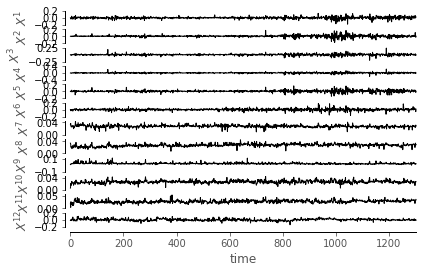

In [82]:
tp.plot_timeseries(dataframe_companies); plt.show()

#### Partial Correlation

In [83]:
parcorr = ParCorr(significance='analytic')

pcmci = PCMCI(
    dataframe=dataframe_companies, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 7


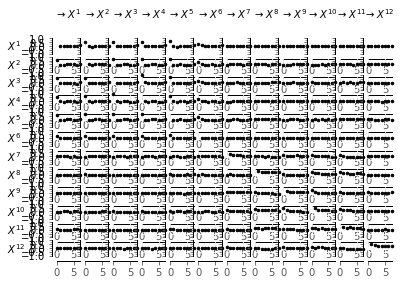

In [96]:
correlations = pcmci.get_lagged_dependencies(tau_max=7, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                    setup_args={'var_names':var_names_companies, 
                                    'x_base':5, 'y_base':.5}, )
plt.show()


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 7


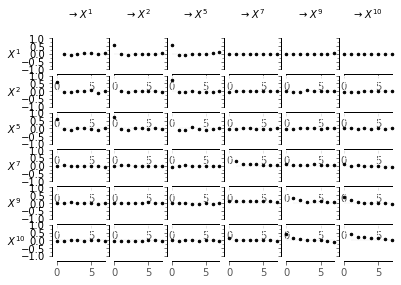

In [109]:
#sample
sample_var_names_companies = [r'$X^1$', r'$X^2$', r'$X^5$', r'$X^7$', r'$X^9$', r'$X^{10}$',]
sample_dataframe_companies = pp.DataFrame(dataFrameCompanies[:, [0, 1, 4, 6, 8, 9]], 
                         datatime = np.arange(len(dataFrameCompanies[:, [0, 1, 4, 6, 8, 9]])), 
                         var_names=sample_var_names_companies)

sample_pcmci = PCMCI(
    dataframe=sample_dataframe_companies, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = sample_pcmci.get_lagged_dependencies(tau_max=7, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                    setup_args={'var_names':sample_var_names_companies, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [104]:
var_names_companies[4:8]

['$X^5$', '$X^6$', '$X^7$', '$X^8$']

In [85]:
results = pcmci.run_pcmci(tau_max=7, pc_alpha=0.05)
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 7
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^1$ has 4 link(s):
        ($X^5$ -2): max_pval = 0.00058, min_val = -0.096
        ($X^7$ -7): max_pval = 0.00994, min_val = -0.072
        ($X^7$ -1): max_pval = 0.03540, min_val =  0.059
        ($X^2$ -5): max_pval = 0.03676, min_val =  0.058

    Variable $X^2$ has 0 link(s):

    Variable $X^3$ has 4 link(s):
        ($X^1$ -7): max_pval = 0.00431, min_val =  0.079
        ($X^6$ -1): max_pval = 0.01012, min_val = -0.072
        ($X^{12}$ -3): max_pval = 0.01737, min_val = -0.066
        ($X^{11}$ -4): max_pval = 0.03896, min_val = -0.058

    Variable $X^4$ has 3 link(s):
        ($X^1$ -7): max_pval = 0.00462, min_val =  0.079
        ($X^6$ -1): max_pval = 0.01185, min_val = -0.070
        ($X^{12}$ -3): max_pval = 0.03492, min_val = -0.059


In [86]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], 
                                        tau_max=7, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^1$ has 7 link(s):
        ($X^5$  0): pval = 0.00000 | qval = 0.00000 | val =  0.597
        ($X^2$  0): pval = 0.00000 | qval = 0.00000 | val =  0.565
        ($X^3$  0): pval = 0.00000 | qval = 0.00000 | val =  0.559
        ($X^4$  0): pval = 0.00000 | qval = 0.00000 | val =  0.554
        ($X^6$  0): pval = 0.00000 | qval = 0.00000 | val =  0.285
        ($X^3$ -6): pval = 0.00008 | qval = 0.00588 | val = -0.110
        ($X^4$ -6): pval = 0.00010 | qval = 0.00714 | val = -0.108

    Variable $X^2$ has 5 link(s):
        ($X^5$  0): pval = 0.00000 | qval = 0.00000 | val =  0.705
        ($X^3$  0): pval = 0.00000 | qval = 0.00000 | val =  0.653
        ($X^4$  0): pval = 0.00000 | qval = 0.00000 | val =  0.651
        ($X^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.565
        ($X^6$  0): pval = 0.00000 | qval = 0.00000 | val =  0.305

    Variable $X^3$ has 6 link(s):
        ($X^4$  0): pval = 0.00000 | qval = 0.00000 

In [87]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

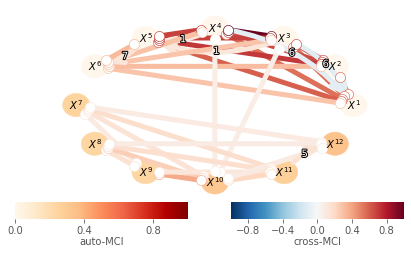

In [88]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    )

plt.show()

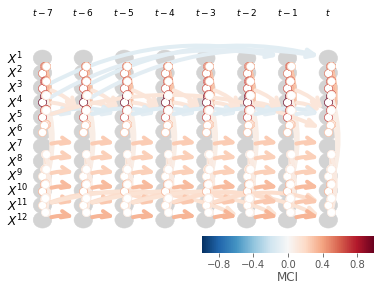

In [89]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='MCI',
    ); plt.show()

#### Gaussian Processes

In [90]:
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe_companies, 
    cond_ind_test=gpdc,
    verbosity=0)

In [91]:
results = pcmci_gpdc.run_pcmci(tau_max=7, pc_alpha=0.05)
pcmci_gpdc.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/diego.sanez/.conda/envs/tigramite/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  Convergen


## Significant links at alpha = 0.01:

    Variable $X^1$ has 8 link(s):
        ($X^5$  0): pval = 0.00000 | val =  0.505
        ($X^4$  0): pval = 0.00000 | val =  0.476
        ($X^2$  0): pval = 0.00000 | val =  0.467
        ($X^3$  0): pval = 0.00000 | val =  0.458
        ($X^6$  0): pval = 0.00000 | val =  0.240
        ($X^{11}$  0): pval = 0.00100 | val =  0.096
        ($X^7$  0): pval = 0.00300 | val =  0.095
        ($X^5$ -1): pval = 0.00700 | val =  0.080

    Variable $X^2$ has 8 link(s):
        ($X^4$  0): pval = 0.00000 | val =  0.640
        ($X^3$  0): pval = 0.00000 | val =  0.558
        ($X^5$  0): pval = 0.00000 | val =  0.549
        ($X^1$  0): pval = 0.00000 | val =  0.467
        ($X^6$  0): pval = 0.00000 | val =  0.288
        ($X^8$  0): pval = 0.00000 | val =  0.153
        ($X^4$ -3): pval = 0.00300 | val =  0.088
        ($X^2$ -1): pval = 0.00400 | val =  0.081

    Variable $X^3$ has 8 link(s):
        ($X^4$  0): pval = 0.00000 | val =  0.981
   

In [92]:
q_matrix = pcmci_gpdc.get_corrected_pvalues(p_matrix=results['p_matrix'], 
                                            tau_max=7, fdr_method='fdr_bh')
pcmci_gpdc.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,  
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^1$ has 7 link(s):
        ($X^5$  0): pval = 0.00000 | qval = 0.00000 | val =  0.505
        ($X^4$  0): pval = 0.00000 | qval = 0.00000 | val =  0.476
        ($X^2$  0): pval = 0.00000 | qval = 0.00000 | val =  0.467
        ($X^3$  0): pval = 0.00000 | qval = 0.00000 | val =  0.458
        ($X^6$  0): pval = 0.00000 | qval = 0.00000 | val =  0.240
        ($X^{11}$  0): pval = 0.00100 | qval = 0.00100 | val =  0.096
        ($X^7$  0): pval = 0.00300 | qval = 0.00300 | val =  0.095

    Variable $X^2$ has 6 link(s):
        ($X^4$  0): pval = 0.00000 | qval = 0.00000 | val =  0.640
        ($X^3$  0): pval = 0.00000 | qval = 0.00000 | val =  0.558
        ($X^5$  0): pval = 0.00000 | qval = 0.00000 | val =  0.549
        ($X^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.467
        ($X^6$  0): pval = 0.00000 | qval = 0.00000 | val =  0.288
        ($X^8$  0): pval = 0.00000 | qval = 0.00000 | val =  0.153

    Variable $X^

In [93]:
link_matrix = pcmci_gpdc.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

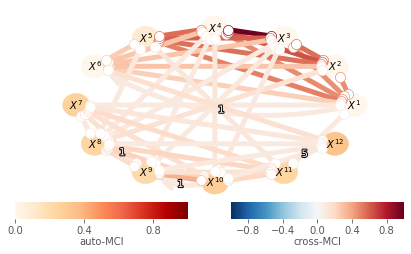

In [94]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

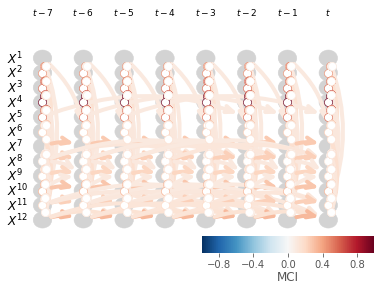

In [95]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='MCI',
    ); plt.show()

Implemented by Diego Saenz